# Compare two Multimodal search CLIP models

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install datasets
!pip install clip open_clip

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/pip-req-build-x9h2o9tw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/pip-req-build-x9h2o9tw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement open_clip (from versions: none)
ERROR: No matching distribution found for open_clip


In [2]:
openai_model_name = "ViT-B/32"
open_clip_model_name = 'ViT-B-32'
open_clip_pretrained='laion2b_s34b_b79k'



In [3]:
import clip
import pymongo
from superduperdb.misc.superduper import superduper
from superduperdb.models.torch.wrapper import TorchModel
from superduperdb.datalayer.mongodb.query import Collection
from superduperdb.core import Document as D
from superduperdb.encoders.pillow.image import pil_image as i
from IPython.display import display

pymongo.MongoClient().drop_database('documents')
pymongo.MongoClient().drop_database('_filesystem:documents')

db = pymongo.MongoClient().documents
db = superduper(db)

collection = Collection(name='tiny-imagenet')

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i
from datasets import load_dataset
import random

dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
dataset = [D({'image': i(r['image'])}) for r in dataset]
dataset = random.sample(dataset, 1000)


/Users/levkonstantinovskiy/Documents/GitHub/new/superduperdb-stealth/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
db.execute(collection.insert_many(dataset, encoders=(i,)))

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x17e0e5390>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x17c1387f0>, G=<networkx.classes.digraph.DiGraph object at 0x17e0e5a80>))

We can verify that the images are correctly stored:

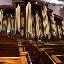

In [6]:
x = db.execute(collection.find_one())['image'].x
x

In [7]:
from superduperdb.core.vector_index import VectorIndex
from superduperdb.core.watcher import Watcher
from superduperdb.encoders.torch.tensor import tensor
import torch

def add_clip_index(index_name, model_identifier, model, preprocess, text_tokenizer,):
    t = tensor(torch.float, shape=(512,))

    text_model = TorchModel(
        identifier=model_identifier+"_text",
        object=model,
        preprocess=text_tokenizer,
        forward_method='encode_text',
        encoder=t
    )
    print(len(text_model.predict('this is a test', one=True)))
    visual_model = TorchModel(
        identifier=model_identifier+"_image",
        preprocess=preprocess,
        object=model.visual,
        encoder=t,
    )
    x = db.execute(collection.find_one())['image'].x
    print(len(visual_model.predict(x, one=True)))


    db.add(
        VectorIndex(
            index_name,
            indexing_watcher=Watcher(
                model=visual_model,
                key='image',
                select=collection.find(),
            ),
            compatible_watcher=Watcher(
                model=text_model,
                key='text',
                active=False,
            )
        )
    )

In [8]:

openai_model, openai_preprocess = clip.load(openai_model_name, device='cpu')
openai_tokenizer = lambda x: clip.tokenize(x)[0]
add_clip_index("openai_clip_index", "openai_clip_model", openai_model, openai_preprocess, openai_tokenizer,)


512
512


Computing chunk 0/0


100%|██████████| 1000/1000 [00:35<00:00, 28.28it/s]
INFO:root:loading hashes: 'openai_clip_index'
/Users/levkonstantinovskiy/Documents/GitHub/new/superduperdb-stealth/superduperdb/encoders/torch/tensor.py:25: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)


In [9]:

import open_clip
open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(open_clip_model_name, pretrained=open_clip_pretrained, device='cpu' )

open_clip_tokenizer = lambda x: open_clip.get_tokenizer(open_clip_model_name)(x)[0] 
add_clip_index("open_clip_clip_index", "open_clip_clip_model", open_clip_model, open_clip_preprocess, open_clip_tokenizer,)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpwzxpz683
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpwzxpz683/_remote_module_non_scriptable.py
INFO:root:Loaded ViT-B-32 model config.
INFO:root:Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


512
512


Computing chunk 0/0


100%|██████████| 1000/1000 [00:38<00:00, 25.95it/s]
INFO:root:loading hashes: 'open_clip_clip_index'


In [10]:
!pip install --quiet gradio 

In [11]:

import pymongo
from superduperdb.misc.superduper import superduper
from superduperdb.datalayer.mongodb.query import Collection
from superduperdb.core.document import Document as D
import clip 
import open_clip

db = pymongo.MongoClient().documents
db = superduper(db)

collection = Collection(name='tiny-imagenet')

cursor = db.execute(
    collection.like(D({'text': 'mushroom'}), vector_index='openai_clip_index', n=10).find({})
)
[(row['image'].x) for row in out]

def _extract(out):
    return [(row['image'].x) for row in out]
_extract(out)

INFO:root:loading hashes: 'openai_clip_index'


NameError: name 'out' is not defined

In [ ]:

def find_image_vectors(query):
    code = (
    f"""
    import pymongo
    from superduperdb.misc.superduper import superduper
    from superduperdb.datalayer.mongodb.query import Collection
    from superduperdb.core.document import Document as D
    import clip 

    db = pymongo.MongoClient().documents
    db = superduper(db)

    collection = Collection(name='tiny-imagenet')

    openai_cursor = db.execute(collection.like(D({{'text': '{query}'}}), vector_index='{'openai_clip_index'}', n=20).find({{}})
    open_clip_cursor = db.execute(collection.like(D({{'text': '{query}'}}), vector_index='{'open_clip_clip_index'}', n=20).find({{}})

    """
 )
    return (_extract(db.execute(collection.like(D({'text': query}), vector_index='openai_clip_index', n=20).find({}))), _extract(db.execute(collection.like(D({'text': query}), vector_index='open_clip_clip_index', n=20).find({}))), code)




In [ ]:
from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i
from datasets import load_dataset
import random
import pymongo
from superduperdb import superduper
from superduperdb.datalayer.mongodb.query import Collection
import clip


db = pymongo.MongoClient().documents
db = superduper(db)

collection = Collection(name='tiny-imagenet')

In [ ]:
import gradio as gr


with gr.Blocks() as demo:
    with gr.Row():
        with gr.Tab("Multi-modal search: compare two models"):
            vector_query = gr.Textbox(value="mushroom", show_label=False)
            b2 = gr.Button("Submit")
    with gr.Row():
        code = gr.Code(label="Code", language="python")
    with gr.Row():
        gr.Label("Similar images from CLIP", show_label=False)
    with gr.Row():
        
        openai_gallery = gr.Gallery(
                label="Trained on OpenAI dataset", show_label=True, elem_id="gallery"
            ).style(columns=[6], rows=[3], object_fit="contain", height="auto")
        open_clip_gallery = gr.Gallery(
                label="Trained on open source LAION-2B", show_label=True, elem_id="gallery"
            ).style(columns=[6], rows=[3], object_fit="contain", height="auto")   

        
    b2.click(find_image_vectors, inputs=vector_query, outputs=[openai_gallery, open_clip_gallery, code])
    
demo.launch()

/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_18414/3144161703.py:15: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  openai_gallery = gr.Gallery(
/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/ipykernel_18414/3144161703.py:18: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  open_clip_gallery = gr.Gallery(


Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.
